---
# Before You Mortgage, Mortgauge.com 
## By Greg Araya
---

## Introduction

Not long ago I started looking around at houses and condos. To make a long dreadful story short, the process to get approved for a mortgage was awful. After too many back and forth calls, meetings, bothersome agents, outright rude interactions, and a seemingly endless amount of documents to fill out, I was completely disenchanted with the whole process. Fast forward to the current day, I came across a dataset from Home Credit Group that contained information from over 300,000 applicants for home loans. It includes a vast amount about each applicant before, during, and after the application process. I thought to myself, what if there was a way I could help others avoid some of the trouble I went through? For this project, I would like to create a model that would be used behind an informative website that tells potential applicants how ready they are to take on a home loan.

In order to accomplish this, I will be starting out with a data set provided by the Home Credit Group. This data set can be found here: [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). Home Credit Group is an international financial institution that was founded in 1997 in the Czech Republic, and headquartered in the Netherlands. They currently operate in 10 countries, so I believe the data set should prove a reasonable sample of applicants. Their data contains application information from over 307,000 applicants, as well as if they had financial troubles during the process.

Using their data set I will utilize a combination of supervised learning and unsupervised learning on the applicants’ personal information, as well as some simple time series analysis on applicants’ credit card histories, to figure out what the most crucial variables are that can predict how likely someone is to successfully navigate a mortgage. Then, using these crucial variables, I intend to create a short form that could be accessed via a website. On this website, users could sign up and fill out this form at their own pace and on their own time. No annoying calls from loan officers rushing you along so they can make their commission off you. You wouldn’t even have to leave your couch or put on pants. This form would be much shorter than the usual applications, and the site would not be directly offering you a loan so there’s no pressure.

I predict that it will be difficult to successfully split applicants into well defined groups with unique features, which is why I intend to do so with a combination of both unsupervised and supervised learning techniques. I also expect that near the end of the project I will have to be wary of class imbalance issues, such as too many people getting rejected, which wouldn’t be a very useful product.

#### But how is this any different than other online mortgage calculators?

This is different than other "mortgage calculators" online because those focus specifically on if you can afford a certain specified amount or not, but don't provide reasons why you don't make it, or provide personalized resources for further research. Also, the available mortgage calculators also all ask for the same info but might miss some of the variables we discover here that ensure success after the loan is obtained. On top of all this, you can fill out the information over time and at your leisure. Take the pesky calls out of the equation, no pushy phone calls about your status and when you’re going to get all your documents together. Lastly, you won't have to worry about any unnecessary hard queries that bring down your credit score

Now that we have all that established, let's jump into the fun.

## Wrangling the Data

Let's begin by uploading all of the modules we'll need. Then we can read in the data and take a look at it.

In [1]:
# The usuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import warnings
from scipy import stats

# Tools we can use on the models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

# Data cleaning and feature importance
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

# Naive Bayes modules
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

# Random Forest modules
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

# K-Means module
from sklearn.cluster import KMeans

Now let's read in the data. These are some pretty big files, so I'm also going to print out how long it takes to process them. I also did some work using Google Colab, so I have my code saved in text form here for ease of reference.

In [2]:
# Start a timer for reference on how long this takes
read_start_time = time.time()

application_df = pd.read_csv('application_train.csv')
bur_df = pd.read_csv('bureau.csv')
burbal_df = pd.read_csv('bureau_balance.csv')
prevapp_df = pd.read_csv('previous_application.csv')
poscash_df = pd.read_csv('POS_CASH_balance.csv')
installs_df = pd.read_csv('installments_payments.csv')
credit_df = pd.read_csv('credit_card_balance.csv')

# Google colab versions #
#application_df = pd.read_csv('/content/drive/My Drive/Thinkful/00_Final_Project/colab_upload/application_train.csv')
#bur_df = pd.read_csv('/content/drive/My Drive/Thinkful/00_Final_Project/colab_upload/bureau.csv')
#burbal_df = pd.read_csv('/content/drive/My Drive/Thinkful/00_Final_Project/colab_upload/bureau_balance.csv')
#prevapp_df = pd.read_csv('/content/drive/My Drive/Thinkful/00_Final_Project/colab_upload/previous_application.csv')
#poscash_df = pd.read_csv('/content/drive/My Drive/Thinkful/00_Final_Project/colab_upload/POS_CASH_balance.csv')
#installs_df = pd.read_csv('/content/drive/My Drive/Thinkful/00_Final_Project/colab_upload/installments_payments.csv')
#credit_df = pd.read_csv('/content/drive/My Drive/Thinkful/00_Final_Project/colab_upload/credit_card_balance.csv')


# Print out how long it took
print("Reading all of the CSVs took " + str(time.time() - read_start_time) + " seconds")

Reading all of the CSVs took 51.02792453765869 seconds


Now that we've uploaded all our information into pandas dataframes, we can move on to...

## Exploratory Data Analysis

Let's first take a look at the information provided by Home Credit Group about each of the tables we just loaded up above.

#### Table Information from Home Credit

application_{train|test}.csv

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

bureau.csv

- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

bureau_balance.csv

- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

POS_CASH_balance.csv

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

credit_card_balance.csv

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

previous_application.csv

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

installments_payments.csv

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

HomeCredit_columns_description.csv

- This file contains descriptions for the columns in the various data files.

![Home Credit Descriptions](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Now that we have a general idea of what this data looks like, let's take a deeper look to find out what's really in it. We can start this process by looking at the shapes of each table and printing out a preview of each.

In [3]:
print('Size of application data:', application_df.shape)
print('Size of bureau data:', bur_df.shape)
print('Size of bureau_balance data:', burbal_df.shape)
print('Size of previous_application data:', prevapp_df.shape)
print('Size of POS_CASH_balance data:', poscash_df.shape)
print('Size of installments_payments data:', installs_df.shape)
print('Size of credit_card_balance data:', credit_df.shape)

Size of application data: (307511, 122)
Size of bureau data: (1716428, 17)
Size of bureau_balance data: (27299925, 3)
Size of previous_application data: (1670214, 37)
Size of POS_CASH_balance data: (10001358, 8)
Size of installments_payments data: (13605401, 8)
Size of credit_card_balance data: (3840312, 23)


In [4]:
application_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
credit_df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


The amount of information contained in these CSV files is pretty immense, but we can do some manual feature reduction right off the bat by considering the goals of this project. Since we want to keep things somewhat simple for users, we can focus more on distinct values rather than long strings of payments. Therefore I'm going to focus on just the main application information as well as the credit card data. For all of the other tables I'll use a flag that will be kept in the main dataframe. This way, if the flag is found to be important, this could turn into a yes or no question on the website. This way we keep track that previous history is or is not found from each user and don't lose all the information in those tables. An example of a question that could spawn from these flag variables is, "Could you provide 2 years of documentation proving your work history and income amount? Yes/No". This will be much simpler than asking them to manually enter such information. This is just an informative tool after all.

Following this, we should begin to clean up the data that we are going to use. Below I will select columns from the dataframes that are relevant to our analysis, and proceed to fill in missing values, process outliers, and investigate anything else that just doesn't look right.

##### Creating the Main Dataframe

I will start our main dataframe by trimming down on what we have in the "application" data set. After that we can combine the useful information from the other spreadsheets into this main dataframe.

In [6]:
# Create a list for the columns we want
feat_columns = ['TARGET', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                        'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
                        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                        'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                        'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
                        'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                        'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
                        'ORGANIZATION_TYPE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
                        'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
                        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
                        'NONLIVINGAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                        'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
                        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                        'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

# Copy our chosen columns into another dataframe
app_df = application_df[feat_columns].copy()

# Print out the size of our data
print('Size of application data:', app_df.shape)

Size of application data: (307511, 58)


For the Bureau, Bureau Balance, POS CASH Balance, Previous Application, and Installment Payments spreadsheets, I believe that these mainly contain information that would be too technical for the audience of this website. However, I wouldn't want to neglect them entirely, and instead choose to make a new flag variable in our data that can simply indicate which of these spreadsheets the applicant shows up in. If found to be important, these flags could be turned into simple questions such as "Can you provide x amount of months of previous loan payments?" or something of that nature.

In [7]:
# Assign the Bureau Flag variable if we find the SK ID in the Bureau dataframe (1 if found 0 if not)
app_df = app_df.assign(BUREAU_FLAG = app_df.SK_ID_CURR.isin(bur_df.SK_ID_CURR).astype(int))

# Assign the Previous Application Flag variable if we find the SK ID in the Bureau dataframe (1 if found 0 if not)
app_df = app_df.assign(PREV_APP_FLAG = app_df.SK_ID_CURR.isin(prevapp_df.SK_ID_CURR).astype(int))

# Assign the POS CASH Flag variable if we find the SK ID in the Bureau dataframe (1 if found 0 if not)
app_df = app_df.assign(POS_CASH_FLAG = app_df.SK_ID_CURR.isin(poscash_df.SK_ID_CURR).astype(int))

# Assign the Installments Flag variable if we find the SK ID in the Bureau dataframe (1 if found 0 if not)
app_df = app_df.assign(INSTALLS_FLAG = app_df.SK_ID_CURR.isin(installs_df.SK_ID_CURR).astype(int))

Although I could have also simply made a flag for the Credit Card Balance spreadsheet like I did above for the other features, I thought this would be much more interesting to look into than the above spreadsheets. Many people have credit cards long before having home loans so this information could prove to be within the technical boundaries of our questions. Thus I will analyze the Credit Card Balance dataframe separately and then bring crucial information back into the dataframe later on.

##### Finding the Missing Values

In [8]:
# First let's make a function that displays a dataframe % of missing information for us
def perc_missing_vals(df):
    
    # Get the total number that is missing to divide with
    tot_miss = df.isnull().sum()
    
    # Obtain the percentage
    missed_perc = 100 * df.isnull().sum() / len(df)
    
    # Create a table that will show our results, set axis=1 to go over the columns
    missing_table = pd.concat([tot_miss, missed_perc], axis=1)
    
    # Rename the columns
    missing_table_cols = missing_table.rename(columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    # Sort by the percentage we're missing (descending) that aren't = 0
    missing_table_cols = missing_table_cols[missing_table_cols.iloc[:,1] != 0].sort_values('% of Total Values',
                                                                                           ascending=False).round(1)
    
    # Print out information
    print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(missing_table_cols.shape[0]) +
              " columns with missing values.")
    
    # Return the missing info dataframe
    return missing_table_cols

##### Missing Values in the Main Dataframe

In [9]:
# Missing values statistics for the data
missing_values = perc_missing_vals(app_df)
missing_values.head(31)

Dataframe has 62 columns.
There are 30 columns with missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_AVG,213514,69.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_AVG,208642,67.8
YEARS_BUILD_AVG,204488,66.5
OWN_CAR_AGE,202929,66.0
LANDAREA_AVG,182590,59.4
BASEMENTAREA_AVG,179943,58.5
NONLIVINGAREA_AVG,169682,55.2
ELEVATORS_AVG,163891,53.3


##### Missing Values in the Credit Card Balance data

In [10]:
# Missing values statistics for the credit card balance data
missing_values = perc_missing_vals(credit_df)
missing_values.head(9)

Dataframe has 23 columns.
There are 9 columns with missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


Now that we know what variables are missing information that we need to fill in, let's also take a look at how variable our non-numeric columns are.

##### The Number of Unique Items Found in Each Non-Numeric Column

In [11]:
# Number of unique classes in each object column of data
app_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [12]:
# Number of unique classes in each object column of credit card data
credit_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_STATUS    7
dtype: int64

A good number of these variables have lots of options, and these values don't particularly have a fixed order. However, we can still analyze these features by utilizing One Hot Encoding (i.e. creating dummy variables using get_dummies(). After that, we will then have to reduce the dimensionality since this will add a lot of features.

### Some Invormative Histograms from the Main Dataframe

##### Target Variable

Before we start filling in missing values, I would also like to learn about the distributions of some of our parameters. Below I have created some visuals to show us what kind of people have applications listed in this data set. First, let's simply see how many people were able to successfully pay off their loans, and how many of them had troubles, by charting the target variable from the data.

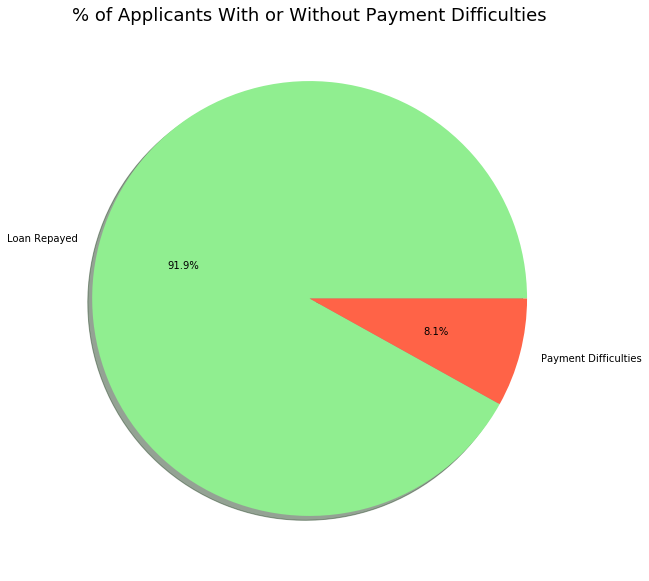

In [13]:
plt.figure(figsize=(10,10))                          # set the size of the figure so it is readable
plt.pie(
    app_df['TARGET'].value_counts(sort=False),     # grab counts of target variable
    labels=['Loan Repayed', 'Payment Difficulties'], # give the slices captions
    autopct='%1.1f%%',                               # set digits of percentages
    colors=['lightgreen', 'tomato'],
    shadow=True)                                     # set a shadow behind the slices

plt.title('% of Applicants With or Without Payment Difficulties', fontsize=18)    # create a title
plt.rcParams["axes.labelweight"] = "bold"                                      # bold the text for readability
plt.show()                                                                     # plot away

This data is clearly imbalanced with many people who had no problems repaying their home loans. We will have to keep that in mind for our testing. Luckily for us, there are supervised learning models that can do the balancing for us. For now though, let's continue to look at a few other variables that I believe will help us get a picture of who these people are.

##### 'NAME_CONTRACT_TYPE'

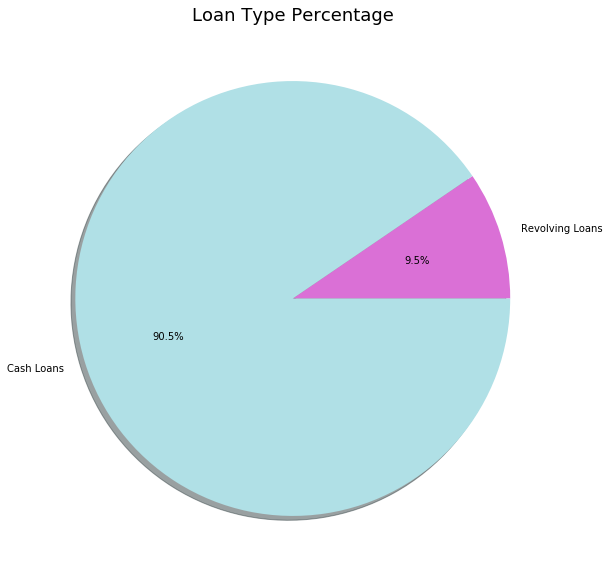

In [14]:
plt.figure(figsize=(10,10))                                      # set the size of the figure so it is readable
plt.pie(
    app_df['NAME_CONTRACT_TYPE'].value_counts(sort=False),     # grab counts of target variable
    labels=['Revolving Loans', 'Cash Loans'],                    # give the slices captions
    autopct='%1.1f%%',                                           # set digits of percentages
    colors=['orchid', 'powderblue'],
    shadow=True)                                                 # set a shadow behind the slices

plt.title('Loan Type Percentage', fontsize=18)                   # create a title
plt.rcParams["axes.labelweight"] = "bold"                        # bold the text for readability
plt.show()                                                       # plot away

##### 'CODE_GENDER'

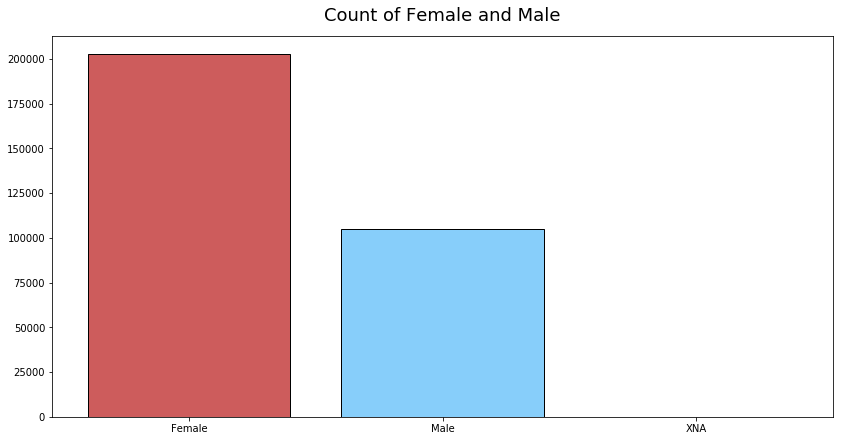

In [15]:
plt.figure(figsize=(14,7))
plt.bar(app_df['CODE_GENDER'].unique(),
        height=app_df['CODE_GENDER'].value_counts(),
        align='center', 
        edgecolor='black',
        color=['indianred', 'lightskyblue'],
        tick_label=['Female', 'Male', 'XNA'])
plt.title('Count of Female and Male', y=1.025, fontsize=18)
plt.show()

##### 'CNT_CHILDREN'

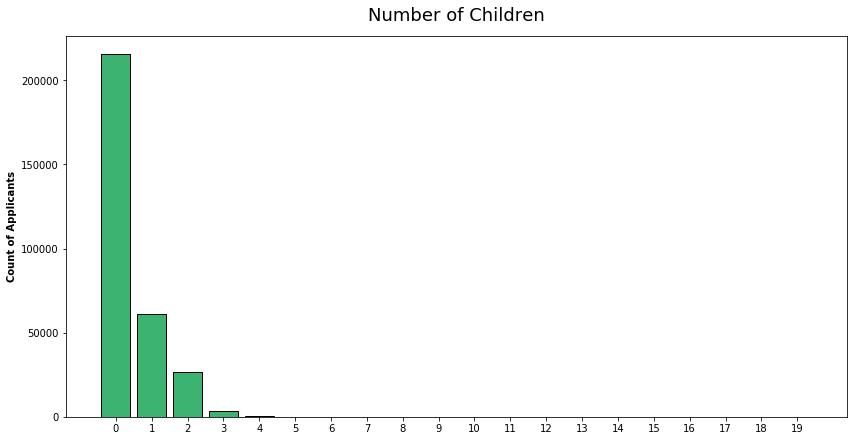

In [16]:
# Get a sorted list of the number of children
num_chil = app_df['CNT_CHILDREN'].unique()
num_chil.sort()

# Plot them out in a bar
plt.figure(figsize=(14,7))
plt.bar(num_chil,
        height=app_df['CNT_CHILDREN'].value_counts(),
        align='center', 
        edgecolor='black',
        color='mediumseagreen')

plt.xticks(range(0,20,1))
plt.title('Number of Children', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.show()

You might be thinking, "Why does this graph go all the way up to 20?" Well, apparently there are two people in this data set who had 19 kids, both of whom I printed out below. Unsurprisingly, they both had issues with paying off their home loans too (see that Target = 0).

In [17]:
app_df[app_df['CNT_CHILDREN'] == 19].head()

,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_FLAG,PREV_APP_FLAG,POS_CASH_FLAG,INSTALLS_FLAG
155369,0,280108,Cash loans,F,N,Y,19,112500.0,269550.0,13891.5,...,0.0,0.0,0.0,0.0,0.0,4.0,1,1,1,1
265784,0,407877,Cash loans,F,N,Y,19,112500.0,135000.0,8788.5,...,0.0,0.0,0.0,0.0,0.0,2.0,1,1,1,1


##### 'AMT_INCOME_TOTAL'

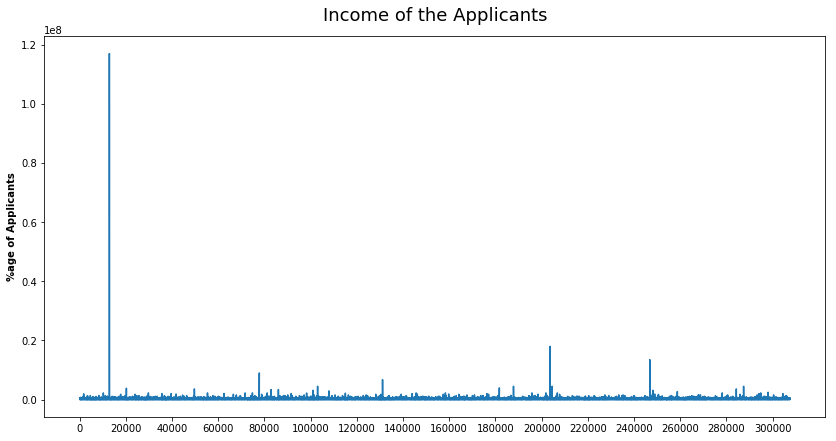

In [18]:
plt.figure(figsize=(14,7))
plt.plot(app_df['AMT_INCOME_TOTAL'])

plt.xticks(range(0,320_000,20_000))
plt.title('Income of the Applicants', y=1.025, fontsize=18)
plt.ylabel('%age of Applicants')
plt.show()

##### 'NAME_INCOME_TYPE'

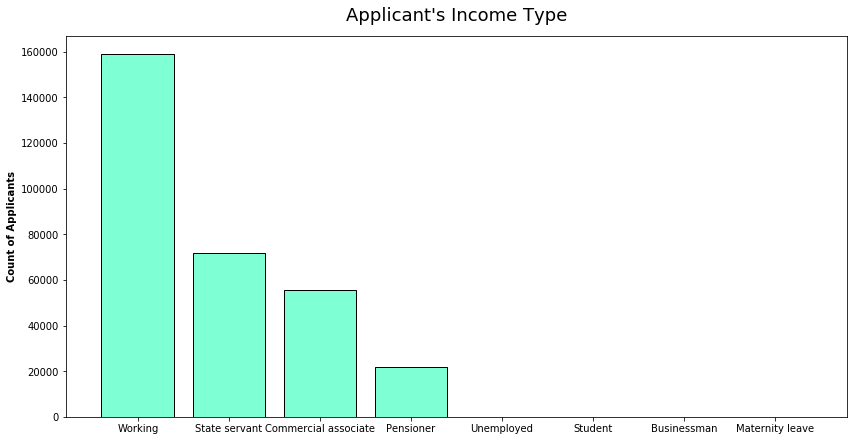

In [19]:
# Make a bar plot of all the Applicants' income type
plt.figure(figsize=(14,7))
plt.bar(app_df['NAME_INCOME_TYPE'].unique(),
        height=app_df['NAME_INCOME_TYPE'].value_counts(),
        align='center', 
        edgecolor='black',
        color='aquamarine')
plt.title('Applicant\'s Income Type', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.show()

##### 'NAME_TYPE_SUITE'

As can be seen above, the number of missing values in the 'NAME_TYPE_SUITE' variable is about 0.4% of people. We can probably assume that these people didn't bring anyone with them and that this data point wasn't recorded in such a situation. Filling these values with "Unaccompanied" shouldn't affect our data too much.

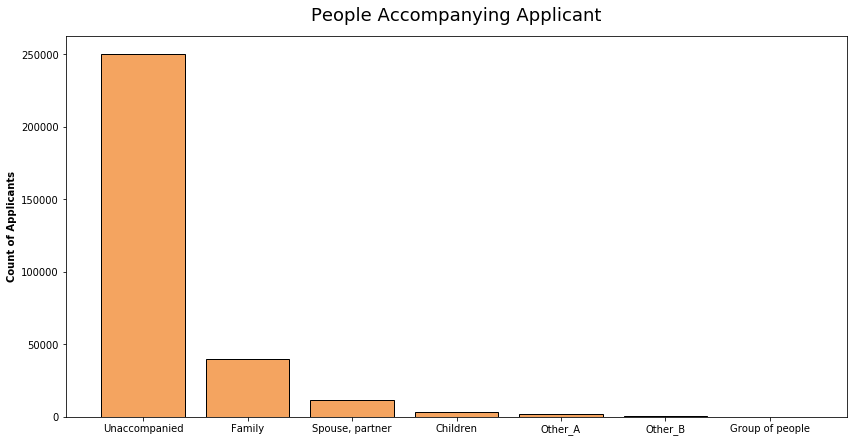

In [20]:
# Fill in NaNs for the NAME_TYPE_SUITE column
app_df['NAME_TYPE_SUITE'].fillna(value='Unaccompanied', inplace=True)

# Make a bar plot of all the Applicants and who they brought with them
plt.figure(figsize=(14,7))
plt.bar(app_df['NAME_TYPE_SUITE'].unique(),
        height=app_df['NAME_TYPE_SUITE'].value_counts(),
        align='center', 
        edgecolor='black',
        color='sandybrown')
plt.title('People Accompanying Applicant', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.show()

##### 'NAME_EDUCATION_TYPE'

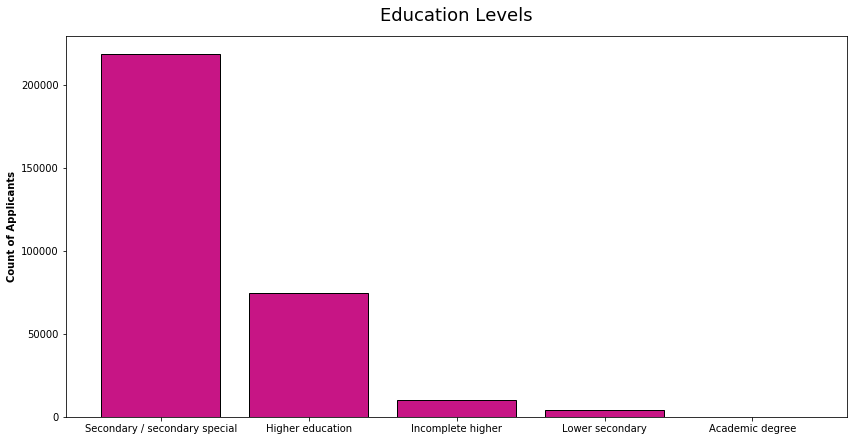

In [21]:
# Make a bar plot of all the education levels
plt.figure(figsize=(14,7))
plt.bar(app_df['NAME_EDUCATION_TYPE'].unique(),
        height=app_df['NAME_EDUCATION_TYPE'].value_counts(),
        align='center', 
        edgecolor='black',
        color='mediumvioletred')
plt.title('Education Levels', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.show()

##### 'NAME_FAMILY_STATUS'

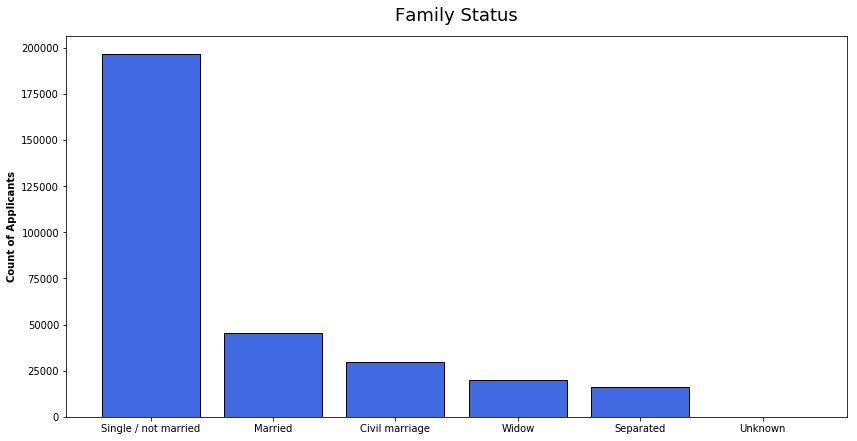

In [22]:
# Make a bar plot of all the family statuses
plt.figure(figsize=(14,7))
plt.bar(app_df['NAME_FAMILY_STATUS'].unique(),
        height=app_df['NAME_FAMILY_STATUS'].value_counts(),
        align='center', 
        edgecolor='black',
        color='royalblue')
plt.title('Family Status', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.show()

##### 'NAME_HOUSING_TYPE'

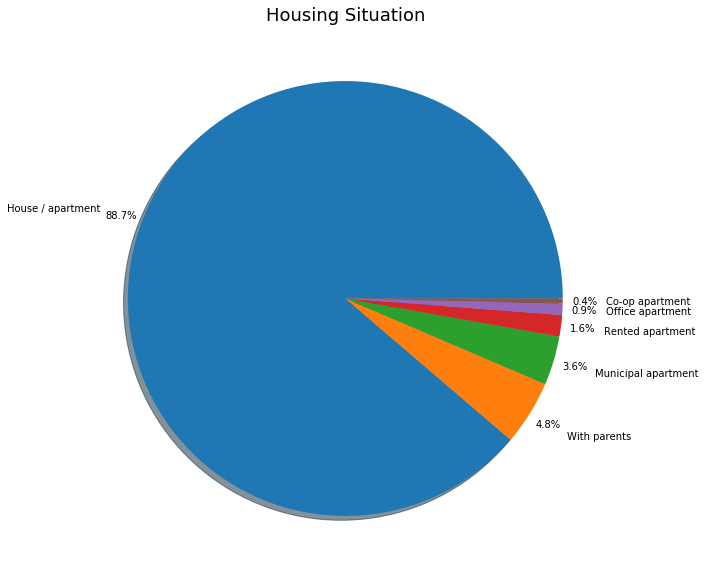

In [23]:
plt.figure(figsize=(10,10))
plt.pie(
    app_df['NAME_HOUSING_TYPE'].value_counts(),
    labels=['House / apartment', 'With parents', 'Municipal apartment', 'Rented apartment',
            'Office apartment', 'Co-op apartment'],
    autopct='%1.1f%%',
    shadow=True,
    pctdistance=1.1,
    labeldistance=1.2)

plt.title('Housing Situation', fontsize=18)
plt.rcParams["axes.labelweight"] = "bold"
plt.show()

##### 'DAYS_BIRTH'

Since this variable tells us the days since birth relative to the day of their application, I'm going to take the absolute value of it to get a number that makes more sense for a graph. Then we can divide by 365 to calculate people's age in years when they applied.

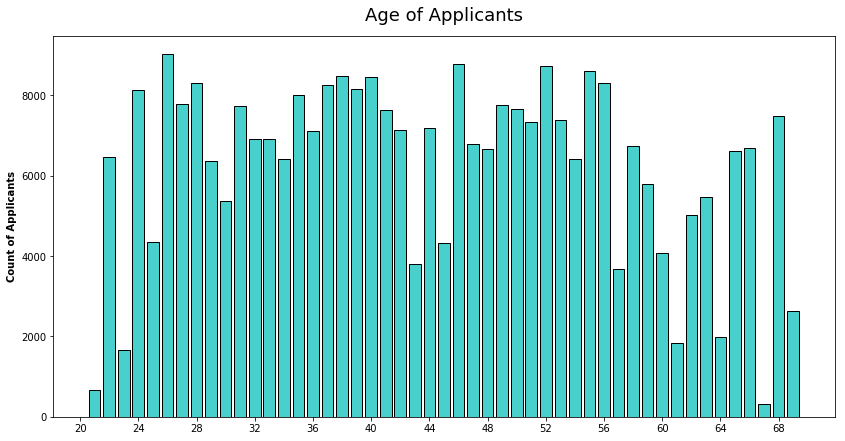

In [24]:
# Take the absolute value of days birth
app_df.loc[:, 'DAYS_BIRTH'] = abs(app_df['DAYS_BIRTH'])

# Create a dataframe to store years
years_birth = pd.DataFrame()

# Calculate the age of each person and round it to an integer
years_birth['YEARS_BIRTH'] = (app_df['DAYS_BIRTH'] / 365)
years_birth['YEARS_BIRTH'] = [round(x) for x in years_birth['YEARS_BIRTH']]

# Make a bar plot
plt.figure(figsize=(14,7))
plt.bar(years_birth['YEARS_BIRTH'].unique(),
        height=years_birth['YEARS_BIRTH'].value_counts(),
        align='center', 
        edgecolor='black',
        color='mediumturquoise')
plt.title('Age of Applicants', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.xticks(range(20,72,4))
plt.show()

##### 'DAYS_EMPLOYED'

Similarly to the days since birth column, this one is also negative. I'll repeat the same process as above to convert to years.

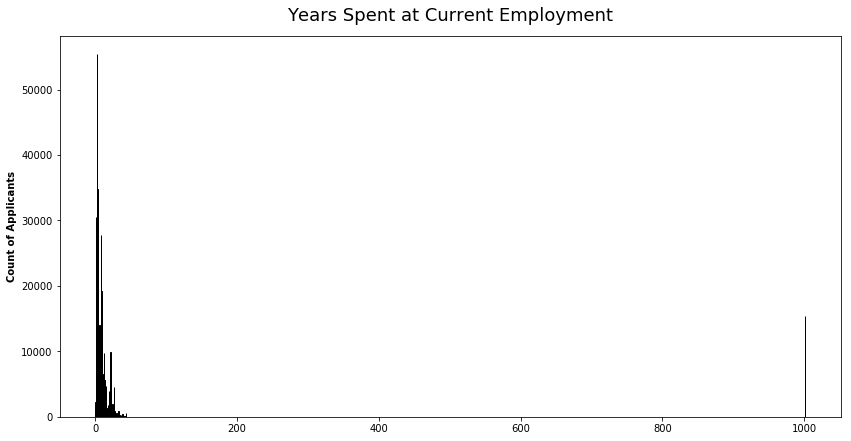

In [25]:
# Take the absolute value of days birth
app_df.loc[:, 'DAYS_EMPLOYED'] = abs(app_df['DAYS_EMPLOYED'])

# Create a dataframe to store years
years_emp = pd.DataFrame()

# Calculate the age of each person and round it to an integer
years_emp['YEARS_EMPLOYED'] = (app_df['DAYS_EMPLOYED'] / 365)
years_emp['YEARS_EMPLOYED'] = [round(x) for x in years_emp['YEARS_EMPLOYED']]

# Make a bar plot
plt.figure(figsize=(14,7))
plt.bar(years_emp['YEARS_EMPLOYED'].unique(),
        height=years_emp['YEARS_EMPLOYED'].value_counts(),
        align='center', 
        edgecolor='black',
        color='forestgreen')
plt.title('Years Spent at Current Employment', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
#plt.xticks(range(20,72,4))
plt.show()

This shows us that there is a very strange outlier in this column. For some reason there is a group of people with unrealistically high numbers of days employed. Let's see how many of these outliers there are before we take any action. One thing that I found is that these outliers were all given the same number, so this must have been a way to identify them in the company's system. By finding out how many of them match the maximum amount we have found we can get a number on how many outliers fit this category.

In [26]:
# Find the length of the dataframe where the days employed is equal to the maximum of this column
print("There are", len(app_df[app_df['DAYS_EMPLOYED'] == app_df['DAYS_EMPLOYED'].max()]),
                              "applicants who claim to have been working for", app_df['DAYS_EMPLOYED'].max(), "days.")

There are 55374 applicants who claim to have been working for 365243 days.


The outlier in this variable has been found to have a value of 365,243 days. This isn't humanly possible as that's over 1,000 years! In order to deal with this I will create a flag for these applicants. Since there are so many of them, this could be interesting information. Then I will take anything that is matching this maximum value and set it to NaN for now.

In [27]:
# Create an anomalous flag column
app_df['DAYS_EMPLOYED_ANOM'] = app_df["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

##### 'OWN_CAR_AGE'

Since there is a flag whether somebody owns a car or not and this flag has no missing values, we can fill in any NA values for the age of somebody's car relative to this flag. If they don't own a car, set the age to zero. Following this, we can see how many empty spots are missing and potentially fill in the rest with the mode.

In [28]:
# Fill in anybody that doesn't have a car to have a car age of zero
app_df.loc[app_df['FLAG_OWN_CAR'] == 'N', 'OWN_CAR_AGE'] = 0

# See how many people are left with a car and an empty car age
print("There are", len(app_df[app_df['OWN_CAR_AGE'].isnull()]),
                                                              "people left with a car but no age listed in this data set.")

There are 5 people left with a car but no age listed in this data set.


Since there are only 5 people in this set, assigning them with the mode of this column won't affect our data much.

In [29]:
# Fill in NaNs for the OWN_CAR_AGE column
app_df['OWN_CAR_AGE'].fillna(value=app_df['OWN_CAR_AGE'].mode()[0], inplace=True)

Now we can go ahead and graph the ages of people's cars.

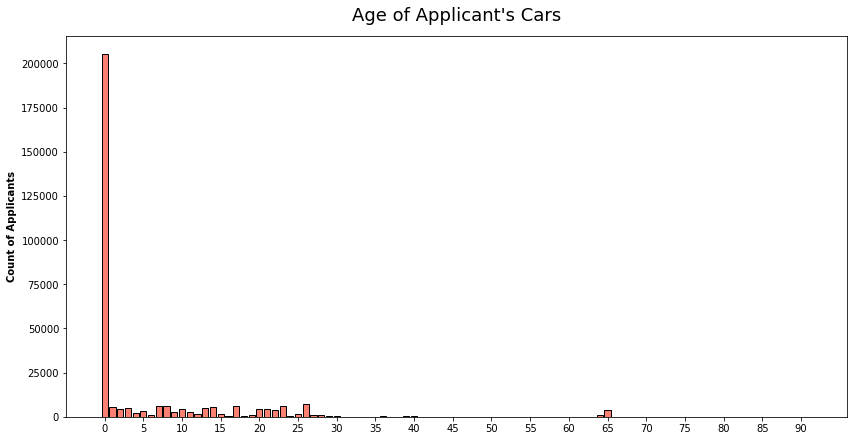

In [30]:
# Plot them out in a bar
plt.figure(figsize=(14,7))
plt.bar(app_df['OWN_CAR_AGE'].unique(),
        height=app_df['OWN_CAR_AGE'].value_counts(),
        align='center', 
        edgecolor='black',
        color='salmon')

plt.xticks(range(0,95,5))
plt.title('Age of Applicant\'s Cars', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.show()

##### 'ORGANIZATION_TYPE'

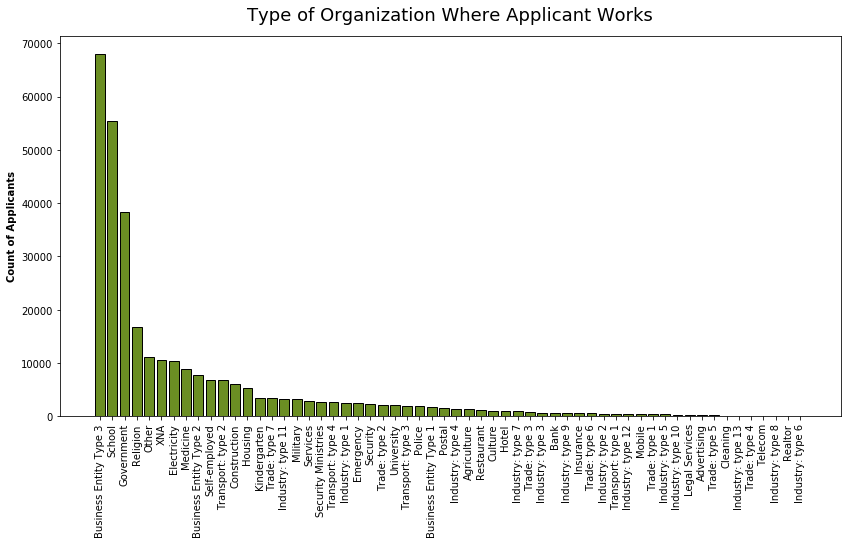

In [31]:
# Make a bar plot
plt.figure(figsize=(14,7))
plt.bar(app_df['ORGANIZATION_TYPE'].unique(),
        height=app_df['ORGANIZATION_TYPE'].value_counts(),
        align='center', 
        edgecolor='black',
        color='olivedrab')
plt.title('Type of Organization Where Applicant Works', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.xticks(rotation=90)
plt.show()

### Some Invormative Histograms of the Credit Card Dataframe

##### 'AMT_BALANCE'

For this variable I would like to just focus on the balances on the most recent balance date, so I'll take a subset of the data to just include the "freshest balance date" (which is = -1 in this data).

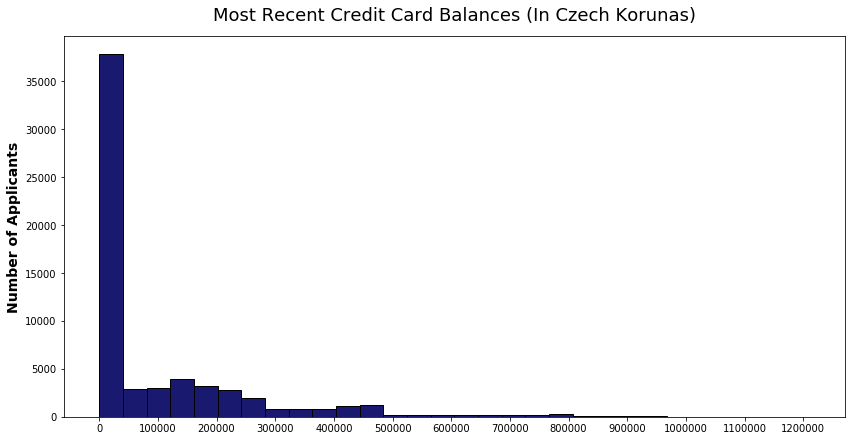

The highest most recent credit card balance is 1210510.755 Czech Korunas


In [32]:
# Copy the information from the most recent balance dates into their own dataframe
recent_balance = credit_df[credit_df['MONTHS_BALANCE'] == -1].copy()

# Make a histogram with binned salary ranges
plt.figure(figsize=(14,7))
plt.hist(
        recent_balance['AMT_BALANCE'],
        bins=30,
        edgecolor='black',
        color='midnightblue')

plt.xticks(range(0,1_300_000,100_000))
plt.ylabel('Number of Applicants', fontsize=14)
plt.title('Most Recent Credit Card Balances (In Czech Korunas)', y=1.025, fontsize=18) 
plt.show()

print("The highest most recent credit card balance is", recent_balance['AMT_BALANCE'].max(), "Czech Korunas")

One thing to make note of here is that the company that this data is from is located in the Czech Republic, so there aren't hundreds of people with over 500,000 USD in credit card debt. In fact the highest recorded balance (printed out above) converts to approximately $52,634.14 US Dollars (given the exchange rate in October 2019).

##### 'NAME_CONTRACT_STATUS'

For this variable I am going to use just the most recent balance history again, otherwise we would overcount the number of applicants that are in each stage of contract at the time of applying.

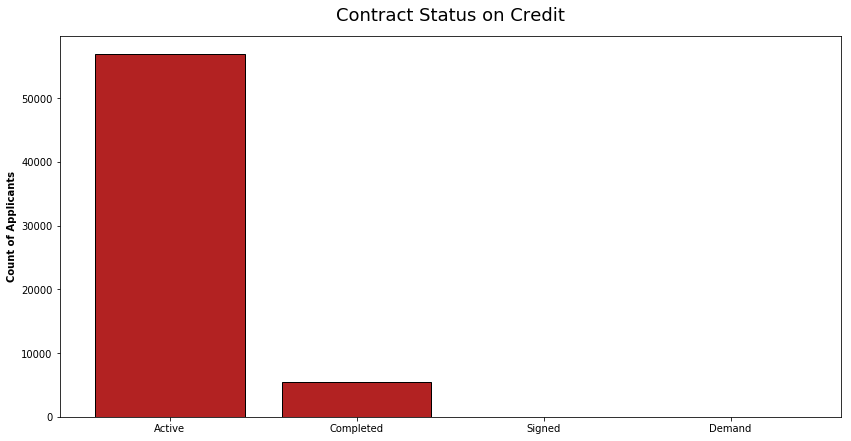

In [33]:
# Make a bar plot
plt.figure(figsize=(14,7))
plt.bar(recent_balance['NAME_CONTRACT_STATUS'].unique(),
        height=recent_balance['NAME_CONTRACT_STATUS'].value_counts(),
        align='center', 
        edgecolor='black',
        color='firebrick')
plt.title('Contract Status on Credit', y=1.025, fontsize=18)
plt.ylabel('Count of Applicants')
plt.show()

### Filling in Empty Values for Main Dataframe

In [34]:
# Missing values statistics for the data
missing_values = perc_missing_vals(app_df)
missing_values.head(31)

Dataframe has 63 columns.
There are 29 columns with missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_AVG,213514,69.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_AVG,208642,67.8
YEARS_BUILD_AVG,204488,66.5
LANDAREA_AVG,182590,59.4
BASEMENTAREA_AVG,179943,58.5
NONLIVINGAREA_AVG,169682,55.2
ELEVATORS_AVG,163891,53.3
APARTMENTS_AVG,156061,50.7


The first thing I notice with all of the missing values, is that the largest percentages of them are related to averages given to the buildings where clients live. If we group by the type of housing reported by each applicant, which doesn't have any empty variables, we can fill in these missing values with the averages given by their respective housing types.

In [35]:
# Make a list of the columns with averages of building information
building_avgs = ['COMMONAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_AVG',
                'YEARS_BUILD_AVG', 'LANDAREA_AVG', 'BASEMENTAREA_AVG', 'NONLIVINGAREA_AVG', 'ELEVATORS_AVG',
                'APARTMENTS_AVG', 'ENTRANCES_AVG', 'LIVINGAREA_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_AVG']

# Iterate through the list and fill in missing values for each based on the housing type group they're in
for avg_col in building_avgs:
    # Group by the housing type and fill in the average of each
    app_df[avg_col] = app_df.groupby(['NAME_HOUSING_TYPE'], sort=False)[avg_col].apply(lambda x: x.fillna(x.mean()))

There are also a cluster of variables that start with "AMT_" that are showing us the number of inquiries made by the applicants before the application was filled out, varying by the amount of time each variable looks at (hours, days, months, etc). Since we have already created flags that tell us if the applicant has loans on file ('BUREAU_FLAG'), we can use those to group by and then fill in the number of inquiries based on that grouping.

In [36]:
# Create a list of inquiry variables to iterate over
inquiry_list = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
               'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

# Iterate thorugh the list of inquiry variables and fill in their averages based on past loan experience
for colmn in inquiry_list:
    app_df[colmn] = app_df.groupby(['BUREAU_FLAG'], sort=False)[colmn].apply(lambda x: x.fillna(x.mean()))

We should also fill out the 'DAYS_EMPLOYED' variable, but first let's check out what sort of people are getting null values for this column.

In [37]:
app_df[app_df['DAYS_EMPLOYED'].isnull()]['NAME_INCOME_TYPE'].unique()

array(['Pensioner', 'Unemployed'], dtype=object)

Considering the only people with missing values in days employed are pensioners or the unemployed, it's safe to fill these values in with zero.

In [38]:
# Set number of days employed to zero when it is empty
app_df['DAYS_EMPLOYED'].fillna(0, inplace=True)

The last large percentage of missing values comes from the Occupation Type variable, which tells us what kind of occupation the client has. However, this one didn't have any obvious connections to other variables, and because there is a little over 30% that are missing, I decided to simply interpolate using the "pad" method for this case.

In [39]:
# Group by the Income Type and fill in the mode for Occupation Type
app_df['OCCUPATION_TYPE'] = app_df['OCCUPATION_TYPE'].interpolate(method='pad')

Following all of the above, the only variables left have 0.3% of missing values or less, so I think it's appropriate to simply fill these in with the averages of their columns.

In [40]:
# Make a list of the variables still left over
misc_missing = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
               'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE']

# Iterate over list and fill in averages
for misc in misc_missing:
    app_df[misc].fillna(app_df[misc].mean(), inplace=True)

In [41]:
# Missing values statistics for the data
missing_values = perc_missing_vals(app_df)

Dataframe has 63 columns.
There are 0 columns with missing values.


### Filling in Empty Values for Credit Card Information

In [42]:
# Missing values statistics for the credit card data
missing_values = perc_missing_vals(credit_df)
missing_values.head(31)

Dataframe has 23 columns.
There are 9 columns with missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


The variable with the most missing values in the credit card information is AMT_PAYMENT_CURRENT, which tells us how much the client paid during the previous period. However, if their previous balance is zero then they wouldn't have to make any payment that month. So let's fill in what we can using that information.

In [43]:
# When the AMT_BALANCE = 0 and the AMT_PAYMENT_CURRENT is empty, fill it with zero
credit_df.loc[(credit_df['AMT_PAYMENT_CURRENT'].isnull()) & (credit_df['AMT_BALANCE'] == 0), 'AMT_PAYMENT_CURRENT'] = 0

It looks like we have 19.5% missing values for a number of variables regarding the amount of drawings from the credit accounts, as well as the count of drawings from the credit accounts, but these missing values are only empty in the specific columns and not the aggregate ones. Therefore, we can say that if the aggregate amount withdrawn (or the aggregate count of times withdrawn) is equal to zero, then all of the subcategories are equal to zero as well. Let's fill those cases in now.

In [44]:
# Create a list of all the missing values in withdrawal variables
draw_amt_list = ['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT']

draw_cnt_list = ['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT']

# Loop through these lists and replace NaN with zero when appropriate
for amt in draw_amt_list:
    credit_df.loc[(credit_df[amt].isnull()) & (credit_df['AMT_DRAWINGS_CURRENT'] == 0), amt] = 0

for cnt in draw_cnt_list:
    credit_df.loc[(credit_df[cnt].isnull()) & (credit_df['CNT_DRAWINGS_CURRENT'] == 0), cnt] = 0

Now we can look at the 'AMT_INST_MIN_REGULARITY' variable. This tells us the minimal installment for this month on previous credit. Let's fill in any values that didn't have any payments as zero.

In [45]:
# When the minimal installment is empty and there is no balance in the previous month, mark minimal installment as zero
credit_df.loc[(credit_df['AMT_INST_MIN_REGULARITY'].isnull()) & (credit_df['AMT_BALANCE'] == 0),
                                                                                      'AMT_INST_MIN_REGULARITY'] = 0

This got rid of the majority of these missing values (0.8% are missing now as opposed to 7.9% before), but there still are a few left. To deal with these, we can sort the dataframe by the applicants' current ID numbers and by the months of their balances, then interpolate over the minimum payments they made in surrounding months.

In [46]:
# Sort by the applicant's ID, and then the month of the balance to get all rows in line
credit_df = credit_df.sort_values(by=['SK_ID_CURR', 'MONTHS_BALANCE'], ascending=False)

# Then interpolate minimum payment linearly from surrounding payment data of applicant
credit_df['AMT_INST_MIN_REGULARITY'].interpolate(method='linear', inplace=True)

Next we can tackle the 'CNT_INSTALMENT_MATURE_CUM' variable, which tells us the number of paid installments on the previous credit. Since this dataframe is already sorted by the ID and the order of monthly balances, we can simply interpolate linearly over their number of installments.

In [47]:
# Then interpolate minimum payment linearly from surrounding payment data of applicant
credit_df['CNT_INSTALMENT_MATURE_CUM'].interpolate(method='linear', inplace=True)

Finally we can fill in the values for the 'AMT_PAYMENT_CURRENT' variable. This tells us how much the client paid during the month on their previous credit. Most clients in this data set have a level monthly payment, so we can feel safe filling in these empty values by taking the average of their payment amounts to estimate the missing months.

In [48]:
# Group by the current ID number and fill in NaN values with the client's average payment
credit_df['AMT_PAYMENT_CURRENT'] = credit_df.groupby(['SK_ID_CURR'], sort=False)['AMT_PAYMENT_CURRENT'].apply(lambda x: x.fillna(x.mean()))

Following this, since there are only 316 missing payment values left out of 3.8 million payments, and the dataframe is already sorted by IDs, I'll interpolate linearly to fill in the final gaps.

In [49]:
# Then interpolate linearly from surrounding payment data of applicant
credit_df['AMT_PAYMENT_CURRENT'].interpolate(method='linear', inplace=True)

In [50]:
# Missing values statistics for the cc data
missing_values = perc_missing_vals(credit_df)

Dataframe has 23 columns.
There are 0 columns with missing values.


### Looking for Anomalies/Outliers

Now we need to detect outliers and assess if they need to be dealt with or if they seem reasonable. First I'll create a list of all of the numeric columns, then I can iterate over it and produce a myriad of box plots.

In [51]:
# Pick up all of the column names for both int types and floating variables
numeric_cols = app_df.select_dtypes('int32').columns.tolist()
numeric_cols.extend(app_df.select_dtypes('int64').columns.tolist())
numeric_cols.extend(app_df.select_dtypes('float').columns.tolist())

# Sort the list for ease of reference later
numeric_cols.sort()

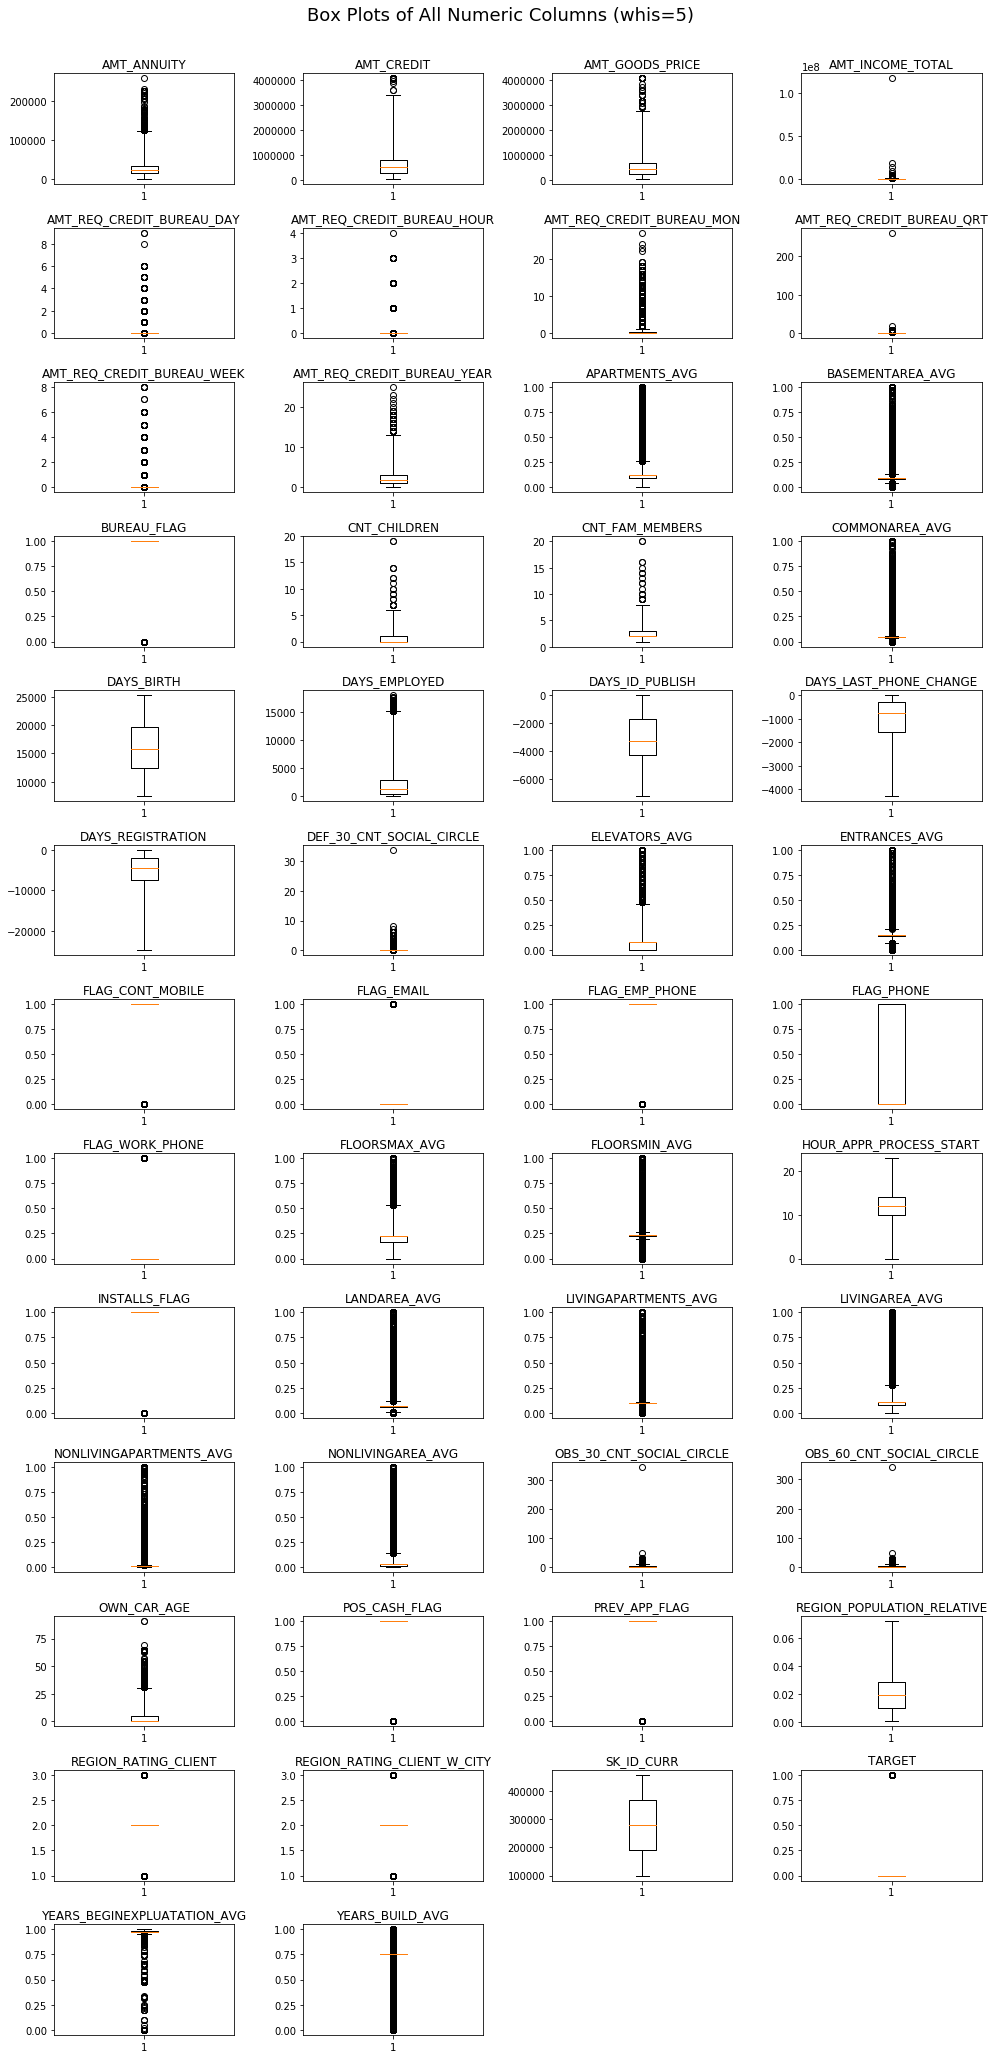

In [52]:
plt.figure(figsize=(14,28))

# Iterate over the column names and create boxplots for each one
for colm in numeric_cols:
    plt.subplot(13, 4, numeric_cols.index(colm) + 1)
    plt.boxplot(app_df[colm], whis=5)
    plt.title("{}".format(colm))

plt.suptitle('Box Plots of All Numeric Columns (whis=5)', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()

Since there seems to be quite a few variables with a number of outliers, let's make a list of all of the variables in question. We can clearly get skip over anything that's a flag of variable with a binary outcome, such as the Target. There were also a number of variables that were normalized in the data set already (the variables that show the averages/modes/medians of building data) so I'll skip over those too.

In [53]:
outlier_list = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY',
                'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
                'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
                'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'DAYS_EMPLOYED', 'DEF_30_CNT_SOCIAL_CIRCLE',
                'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OWN_CAR_AGE']

Now we can take care of most of these outliers by winsorizing each column in our outlier list to cap off values at 90%.

In [54]:
# Loop over each column in outlier list and winsorize to 90%
for col in outlier_list:
    app_df[col] = winsorize(app_df[col], (0, 0.10))

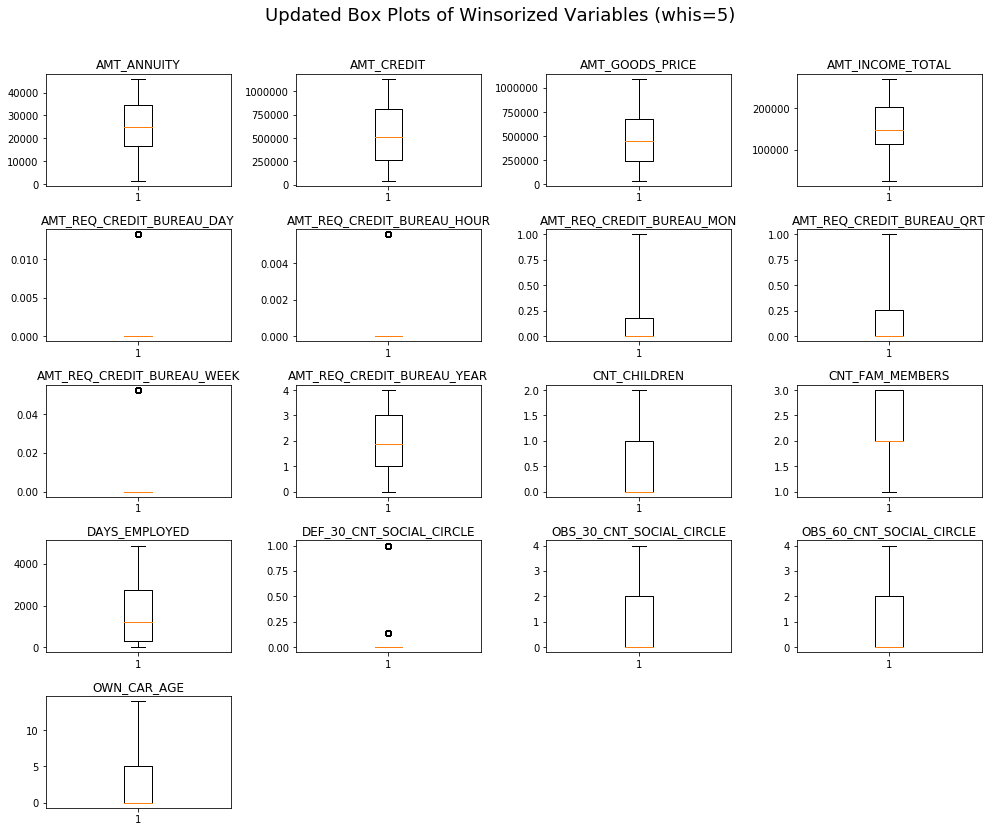

In [55]:
plt.figure(figsize=(14,28))

# Iterate over the column names and create boxplots for each one
for colm in outlier_list:
    plt.subplot(13, 4, outlier_list.index(colm) + 1)
    plt.boxplot(app_df[colm], whis=5)
    plt.title("{}".format(colm))

plt.suptitle('Updated Box Plots of Winsorized Variables (whis=5)', y=1.02, fontsize=18)
plt.tight_layout()
plt.show()

#### Time Series and Other Analysis on Credit Card Information

Now we can return to the credit card dataframe and extract potentially useful information from this. For this step, I want to add three new variables:

1. The trend of percentage credit utilization over time by each applicant.
2. Average number of drawings each loan participant has.
3. The type of contract status.

Let's take a look at these and bring them back into our main dataframe.

##### 1. Trend of % Credit Utilization by Customer

In [56]:
# Create a new column that calculates the percentage of credit being utilized
credit_df['PERC_CREDIT_UTILIZED'] = credit_df['AMT_BALANCE'] / credit_df['AMT_CREDIT_LIMIT_ACTUAL']

# Then create a column that calculates the differences between months of credit utilization
credit_df['DIFF_CREDIT_UTILIZED'] = credit_df['PERC_CREDIT_UTILIZED'] - credit_df['PERC_CREDIT_UTILIZED'].shift(1)

# Create a new dataframe that captures all differences in credit except most recent month
util_df = credit_df[credit_df['MONTHS_BALANCE'] != -1][['SK_ID_CURR', 'DIFF_CREDIT_UTILIZED']].copy()

# Fill in NaNs with zero change because some policies tried to divide by zero above
util_df['DIFF_CREDIT_UTILIZED'].fillna(0, inplace=True)

# Take a look at it
util_df.head(12)

,SK_ID_CURR,DIFF_CREDIT_UTILIZED
1049726,456250,0.025266
1154348,456250,0.023696
310299,456250,-0.002234
1437743,456250,0.018087
431924,456250,0.013884
2248506,456250,0.013849
2985617,456250,0.015462
3734047,456250,0.018432
1684283,456250,0.033560
3611324,456250,0.075730


In [57]:
# Take the mean for each applicant to get a general trend, grouped by the current ID
credit_util_trend = util_df.groupby(['SK_ID_CURR'], sort=False).mean().reset_index()

# Name columns for trend
credit_util_trend.columns = ['SK_ID_CURR', 'TREND_CREDIT_UTILIZED']

# Take a look at it
credit_util_trend.head()

,SK_ID_CURR,TREND_CREDIT_UTILIZED
0,456250,0.012230
1,456248,-0.043960
2,456247,0.005426
3,456246,-0.039511
4,456244,0.017436


In [58]:
# Merge the new trend column into our main dataframe
app_df = pd.merge(app_df, credit_util_trend)

# Fill in empty values for applicants who don't have any credit with zero
app_df['TREND_CREDIT_UTILIZED'].fillna(0, inplace=True)

##### 2. Average Number of Drawings

In [59]:
# Take the mean of each column, grouped by the current ID
avg_drawings = credit_df.groupby(['SK_ID_CURR'], sort=False).mean()

# Slice out just the columns we're looking at to bring back to the main table
avg_drawings = avg_drawings[['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
                             'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT']].reset_index()

# Take a look at it
avg_drawings.head()

,SK_ID_CURR,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT
0,456250,0.666667,0.666667,0.0,0.000000
1,456248,0.000000,0.000000,0.0,0.000000
2,456247,0.115789,0.147368,0.0,0.031579
3,456246,0.000000,2.500000,0.0,2.500000
4,456244,1.048780,1.365854,0.0,0.317073


In [60]:
# Merge these new columns into our main dataframe
app_df = pd.merge(app_df, avg_drawings)

##### 3. Credit Card Contract Statuses

In [61]:
# Create a new dataframe with just the ID's and contract statuses
cc_contracts = credit_df[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']]

#Rename column to be more descriptive in the main df
cc_contracts.columns = ['SK_ID_CURR', 'CREDITCARD_CONTRACT_STATUS']

# Merge with the main dataframe
app_df = pd.merge(app_df, cc_contracts)

#### Applying Domain Specific Features

Following these new credit card variables, I would also like to add some domain specific features to see how much they might effect our models. All home loan offices will look at an applicant's debt to income ratio, as well as precious payment schedules, to get an idea of their credit standing. Let's add those now using variables we already have.

In [62]:
# Create Debt Income Ratio column
app_df['DEBT_INCOME_RATIO'] = app_df['AMT_CREDIT'] / app_df['AMT_INCOME_TOTAL']

# Length of payment schedule (in months)
app_df['LENGTH_PAYMENT'] = app_df['AMT_ANNUITY'] / app_df['AMT_CREDIT']

##### Correlation Analysis

Now that we have all of the variables that we want to include in our models we can print out our top 30 most correlated variables (15 positive and 15 negative).

In [63]:
# Find correlations with the target and sort
correlations = app_df.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(16))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 AMT_REQ_CREDIT_BUREAU_HOUR     0.015145
AMT_REQ_CREDIT_BUREAU_YEAR     0.018375
OBS_60_CNT_SOCIAL_CIRCLE       0.019473
OBS_30_CNT_SOCIAL_CIRCLE       0.019744
FLAG_WORK_PHONE                0.022436
DEF_30_CNT_SOCIAL_CIRCLE       0.022577
DAYS_ID_PUBLISH                0.026896
FLAG_EMP_PHONE                 0.032295
DAYS_REGISTRATION              0.033913
CNT_DRAWINGS_POS_CURRENT       0.040253
DAYS_LAST_PHONE_CHANGE         0.051414
REGION_RATING_CLIENT           0.053819
CNT_DRAWINGS_CURRENT           0.055691
REGION_RATING_CLIENT_W_CITY    0.056235
CNT_DRAWINGS_ATM_CURRENT       0.085195
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 DAYS_BIRTH                   -0.059438
TREND_CREDIT_UTILIZED        -0.038276
DAYS_EMPLOYED_ANOM           -0.032278
DAYS_EMPLOYED                -0.031107
REGION_POPULATION_RELATIVE   -0.026930
AMT_GOODS_PRICE              -0.026463
HOUR_APPR_PROCESS_START      -0.023337

Looks like days of birth is negative, we could make that positive so we see the negative correlation, i.e. as they get older they're more likely to pay off loan. We could also convert this to years since birth if we want to make it more digestable.

##### Correlation Distribution Plots

To get an idea of how some of our most correlated variables are distributed, we can use a KDE plot (kernel density estimation plot) from Seaborn. This shows us the distribution of a single variable color coded to the value of the target to show differences between applicants who could and could not meet their obligations.

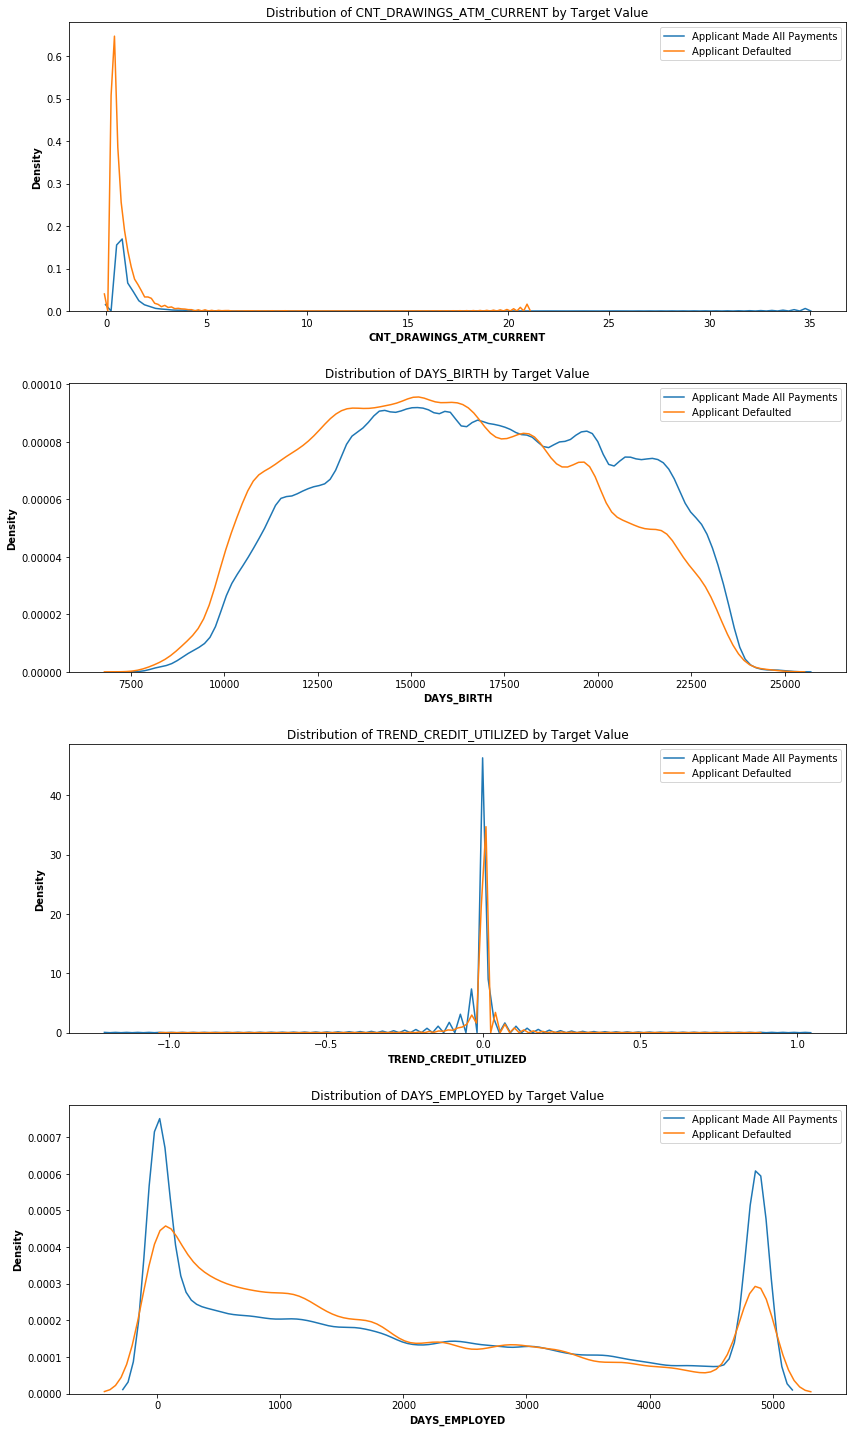

In [64]:
plt.figure(figsize = (12, 20))

# iterate through the new features
for i, feature in enumerate(['CNT_DRAWINGS_ATM_CURRENT', 'DAYS_BIRTH', 'TREND_CREDIT_UTILIZED', 'DAYS_EMPLOYED']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    
    # plot repaid loans
    sns.kdeplot(app_df.loc[app_df['TARGET'] == 0, feature], label = 'Applicant Made All Payments')
    
    # plot loans that were not repaid
    sns.kdeplot(app_df.loc[app_df['TARGET'] == 1, feature], label = 'Applicant Defaulted')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Looking at 'CNT_DRAWINGS_ATM_CURRENT' I notice that most applicants have a low number of drawings, this initially doesn't seem that interesting then. However, on closer inspection you can also see that the applicants who had defaulted on their payments had a noticeable spike in the low 20 region. This could indicate that they tend to have a habit of spending more even despite having to go through an ATM first. We can tell by looking at the 'DAYS_BIRTH' plot that generally those who were able to pay their debts were also older, not a big surprise there. The trend of utilization of credit variable 'TREND_CREDIT_UTILIZED' shows us that the applicants who defaulted are more likely to have an increasing rate of credit utilized, which also makes sense. Lastly, the 'DAYS_EMPLOYED' also shows us that people who were able to pay for their mortgages generally worked at their most recent employer for longer. All of the above checks out so far, so let's move on to finding our critical variables and running some models.

## Find Critical Variables

We'll begin by using SelectFromModel to whittle down the large number of variables we currently have. My computer wouldn't be able to run all of these simultaneously even if they were all valuable. Following this, we'll build a few pipelines that will take one last subsection of the variables using SelectKBest before running it through a CV Search to get the best parameters to be used for each model. Lastly, we'll evaluate the output of each model with descriptive statistics in order to determine what will be used for our final model. Let's get started by converting the categorical columns into numbers with one hot encoding so we can adequately analyze them.

##### Make Dummy Variables for the Categorical Columns

In [65]:
# Create a list of all of the categorical columns, as well as our boolean anomaly column
cat_list = app_df.select_dtypes('object').columns.tolist()
cat_list.append('DAYS_EMPLOYED_ANOM')

# Use the categorical list to get dummies for all of those columns
app_df = pd.get_dummies(app_df, columns=cat_list)

# Replace spaces in new dummy column names with underscores
app_df.columns = app_df.columns.str.replace(' ', '_')

# Recast new dummy columns as int variables since some came out as unsigned integers, cause errors
# Make list of columns with 'uint8' data type
u_int_list = app_df.select_dtypes('uint8').columns.tolist()

# Reassign all as numeric values
app_df[u_int_list] = app_df[u_int_list].astype(int)

# Replace inf values with zero
app_df.loc[app_df['TREND_CREDIT_UTILIZED'].index[np.isinf(app_df).any(1)], 'TREND_CREDIT_UTILIZED'] = 0

Now we have replaced all of the categorical columns with numerical dummies. We can finally start running this data through models to achieve our goals. Let's start by splitting up our data for training and testing and then finding our best features.

##### Splitting the Data into Training and Testing Sets

In [66]:
# Create a list of all columns except the ID numbers and Target variable
var_list = app_df.columns.tolist()
var_list.remove('TARGET')
var_list.remove('SK_ID_CURR')

# Label our features and target
X = app_df[var_list]
Y = app_df['TARGET']

# Split up our training and testing data, 20/80
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

##### Use Random Forest Inside of SelectFromModel to Select Most Important Features

In [67]:
# Create our select from model instance
select_model = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=42), threshold='median')

# Fit the training data to it
select_model.fit(X_train, y_train)

# Transform the features to get a new select version
X_train_s = select_model.transform(X_train)

# Print out before and after sizes to compare
print('The shape of X_train is:', X_train.shape)
print('The shape of X_train_s is:', X_train_s.shape)

The shape of X_train is: (2582068, 185)
The shape of X_train_s is: (2582068, 93)


In [68]:
# Get a true/false list of the selected features 
feat_mask = select_model.get_support()

# Make a list of the columns that were selected
chosen_list = []
i = 0

# Create a list with the column names we want
for choice in feat_mask:
    if choice == True:
        chosen_list.append(X_train.columns[i])
    i += 1

This data is still a bit bigger than I was hoping coming in with 93 variables, though it did cut the number of features we're using in half. However, I'm going to run it through this process once again. Hopefully we can get around 40-50 features to use in our models.

In [69]:
# Take just the columns we want from our feature selection so far
X_train = X_train[chosen_list]

In [70]:
# Create our select from model instance
select_model = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=42), threshold='median')

# Fit the training data to it
select_model.fit(X_train, y_train)

# Transform the features to get a new select version
X_train_s2 = select_model.transform(X_train)

# Print out before and after sizes to compare
print('The shape of X_train is:', X_train.shape)
print('The shape of X_train_s is:', X_train_s2.shape)

The shape of X_train is: (2582068, 93)
The shape of X_train_s is: (2582068, 47)


That's what I'm talking about, only 47 features are left now. Let's create a boolean mask that will track which columns we should keep so we can use this feature list to reassign our data.

In [71]:
# Get a true/false list of the selected features 
feat_mask = select_model.get_support()

# Make a list of the columns that were selected
chosen_list = []
i = 0

# Create a list with the column names we want
for choice in feat_mask:
    if choice == True:
        chosen_list.append(X_train.columns[i])
    i += 1

## Predict Applicants' Ability to Pay Loan

For each of these models we'll be following the same general work flow. Create a distribution of the parameters we want to test, create a pipeline that contains SelectKBest and the model we want to tune for, run a Randomized CV Search on the pipeline using the parameter distribution, and finally use the best parameters that are selected by this search to run through a pipeline one time to get specific output. This process will be repeated until the output has some productive capacity. Let's start with a Naive Bayes model, work on a Random Forest model, and finish with a K-Means model.

###### Note: There are some commented out bits of code in this portion, this is because I had to run the cross validation sections through on Google colab in order to meet the computing requirements that my personal computer lacked.

##### Form the Testing and Training Data

In [72]:
# Label our features and target
X = app_df[chosen_list]
Y = app_df['TARGET']

# Split up our training and testing data, 20/80
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

# For Google Colab runs
#X.to_csv(r'app_df_X.csv', header=True, index=False)
#Y.to_csv(r'app_df_Y.csv', header=True, index=False)

### Naive Bayes Model

Create the parameter distribution and initial pipeline, then run them through a cross validation search.

In [73]:
# Specify the distribution of parameters that we want to test
nb_prm_dist = dict(
    fcl__k = [i for i in np.arange(10, 40, 2)],
    clf__alpha = [i for i in np.arange(0.1,1.1,0.1)], 
    clf__binarize = [i for i in np.arange(0.1,1.1,0.1)], 
    clf__fit_prior = [True, False]
    )

In [74]:
# Create a pipeline that will take us through the modeling process
nb_base_pipeline = Pipeline([
    # Select the best features to train from using the f_classif algorithm
    ('fcl', SelectKBest(f_classif)),
    
    # Choose our classifier algorithm
    ('clf', BernoulliNB())
])

In [75]:
### DON'T DELETE ###
# Start a timer for the NB's CV search
#nbcv_start_time = time.time()

# Set up the random search with our parameter distribution
#nb_rand_search = RandomizedSearchCV(nb_base_pipeline, nb_prm_dist, n_iter=10, cv=10)

# Fit the random search to our data
#nb_rand_search.fit(X_train, y_train.values.ravel())

Now that the cross validation is complete we can take a look at our best parameters.

In [76]:
### DON'T DELETE ###
#print(nb_rand_search.best_params_)
#print("The Naive Bayes' CV search took " + str(time.time() - nbcv_start_time) + " seconds")

'''### BEST OUTPUT ###
{'fcl__k': 20, 'clf__fit_prior': True, 'clf__binarize': 0.30000000000000004, 'clf__alpha': 0.6}
The Naive Bayes' CV search took 667.6867573261261 seconds'''

"### BEST OUTPUT ###\n{'fcl__k': 20, 'clf__fit_prior': True, 'clf__binarize': 0.30000000000000004, 'clf__alpha': 0.6}\nThe Naive Bayes' CV search took 667.6867573261261 seconds"

Now we have our best parameters, so we can go ahead and use these as assigned variables and plug them into an updated pipeline.

In [77]:
# Assign our best parameters to variables to use in an updated pipeline
nb_k = 20                      # nb_rand_search.best_params_['fcl__k']
nb_alpha = 0.6                 # nb_rand_search.best_params_['clf__alpha']
nb_fit_prior = True            # nb_rand_search.best_params_['clf__fit_prior']
nb_binarize = 0.3              # nb_rand_search.best_params_['clf__binarize']

In [78]:
# Create a pipeline that will take us through the modeling process using our new parameters
nb_pipeline = Pipeline([
    # Find the best features to train from using the f_classif algorithm
    ('fcl', SelectKBest(f_classif, k = nb_k)),
    
    # Choose our classifier algorithm
    ('clf', BernoulliNB(
                        alpha = nb_alpha, 
                        binarize = nb_binarize,
                        fit_prior = nb_fit_prior
                        )
    )
])

In [79]:
# Start a timer for the NB model
nb_start_time = time.time()

# Now we can fit our model to use for predictions
nb_model = nb_pipeline.fit(X_train, y_train.values.ravel())

In [80]:
# See how our model performs
print("The Naive Bayes model's accuracy on the test set is: " + str(nb_model.score(X_test, y_test)))
print("The Naive Bayes model took " + str(time.time() - nb_start_time) + " seconds")

The Naive Bayes model's accuracy on the test set is: 0.9291312234999233
The Naive Bayes model took 11.65890121459961 seconds


In [81]:
y_nb_true = Y
y_nb_pred = nb_model.predict(X)

print(classification_report(y_nb_true, y_nb_pred))

c:\users\garaya\python\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.93      1.00      0.96   2997636
           1       0.00      0.00      0.00    229949

    accuracy                           0.93   3227585
   macro avg       0.46      0.50      0.48   3227585
weighted avg       0.86      0.93      0.89   3227585



Looking at the classification report, this model did an awful job at prediction. It was completely unable to predict when an applicant would have problems meeting their financial obligations. You can see this by looking down the "1" row where it produces 0's straight across. I believe this has happened because (as we saw earlier) this data is extremely unbalanced between the two classes. Let's instead try a model that has a balancing parameter that we can utilize.

### Random Forest

We'll follow the same workflow as above here for the Random Forest.

In [82]:
# Specify the distribution of parameters that we want to test
rafo_prm_dist = dict(
    fcl__k = [i for i in np.arange(10, 40, 2)],
    clf__n_estimators = [i for i in np.arange(30, 60, 5)],
    clf__criterion = ['gini', 'entropy'],
    clf__max_depth = [i for i in np.arange(40, 90, 5)],
    clf__max_features = ['auto', 'sqrt', 'log2']
    )

In [83]:
rafo_base_pipeline = Pipeline([
    # Select the best features to train from using the f_classif algorithm
    ('fcl', SelectKBest(f_classif)),
    
    # Choose our classifier algorithm
    ('clf', ensemble.RandomForestClassifier())
])

In [84]:
### DON'T DELETE ###
# Start a timer for the random forest's CV search
#rfcv_start_time = time.time()

# Set up the random search with our parameter distribution
#rafo_rand_search = RandomizedSearchCV(rafo_base_pipeline, rafo_prm_dist, n_iter=5, cv=10)

# Fit the random search to our data
#rafo_rand_search.fit(X_train, y_train.values.ravel())

In [85]:
### DON'T DELETE ###
#print(rafo_rand_search.best_params_)
#print("The Random Forest's CV search took " + str(time.time() - rfcv_start_time) + " seconds")

'''### BEST OUTPUT ###
{'fcl__k': 22, 'clf__n_estimators': 55, 'clf__max_features': 'sqrt', 'clf__max_depth': 55, 'clf__criterion': 'entropy'}
The Random Forest's CV search took 34508.26267552376 seconds'''

"### BEST OUTPUT ###\n{'fcl__k': 22, 'clf__n_estimators': 55, 'clf__max_features': 'sqrt', 'clf__max_depth': 55, 'clf__criterion': 'entropy'}\nThe Random Forest's CV search took 34508.26267552376 seconds"

Now that we have our best parameters for this model, let's run them through an updated pipeline and produce another classification report to see how it did.

In [86]:
# Assign our best parameters to variables to use in an updated pipeline
#            Assign             #  google or local run   #                original command                     #
rafo_k = 18                     #      18 or 22          # rafo_rand_search.best_params_['fcl__k']             #
rafo_n_estimators = 40          #      40 or 55          # rafo_rand_search.best_params_['clf__n_estimators']  #
rafo_criterion = 'gini'         #  'gini' or 'entropy'   # rafo_rand_search.best_params_['clf__criterion']     #
rafo_max_depth = 35             #      35 or 55          # rafo_rand_search.best_params_['clf__max_depth']     #
rafo_max_features = 'log2'      #  'log2' or 'sqrt'      # rafo_rand_search.best_params_['clf__max_features']  #

In [87]:
# Create a pipeline that will take us through the modeling process
rafo_pipeline = Pipeline([
    # Select the best features to train from using the f_classif algorithm
    ('fcl', SelectKBest(f_classif, k = rafo_k)),
    
    # Choose our classifier algorithm
    ('clf', ensemble.RandomForestClassifier(
                                            n_estimators = rafo_n_estimators, 
                                            criterion = rafo_criterion,
                                            max_depth = rafo_max_depth,
                                            max_features = rafo_max_features
                                            ))
])

In [88]:
# Start a timer for the random forest
rf_start_time = time.time()

# Now we can fit our model to use for predictions
rafo_model = rafo_pipeline.fit(X_train, y_train.values.ravel())

In [89]:
# See how our model performs
print("The Random Forest Classification model's accuracy on the test set is: " + str(rafo_model.score(X_test, y_test)))
print("The Random Forest took " + str(time.time() - rf_start_time) + " seconds")

The Random Forest Classification model's accuracy on the test set is: 0.9999829593953374
The Random Forest took 749.2779092788696 seconds


In [90]:
y_rafo_true = Y
y_rafo_pred = rafo_model.predict(X)

print(classification_report(y_rafo_true, y_rafo_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2997636
           1       1.00      1.00      1.00    229949

    accuracy                           1.00   3227585
   macro avg       1.00      1.00      1.00   3227585
weighted avg       1.00      1.00      1.00   3227585



This model was fantastic, it was able to correctly identify every customer! We could just stop here since the Random Forest model can provide us with our "yes" or "no" answers for the website, but let's see if we can try and group candidates to also give them group specific guidance on the website.

## Group Candidates

I planned to take this step so that I can place people into groups, for example, "very qualified, somewhat qualified, almost qualified, not qualified" or something to that affect. In order to create these clusters, I will be employing the K-Means model. However, before we can jump into this model we need to standardize our features. This is because K-Means uses the Euclidean distance measure, which is sensitive to magnitudes, and hence all the features to weigh in equally.

##### Select our best features

In [91]:
# If the above doesn't work on the pipeline, can also try rerunning just the select K best bit and use this
X_features = SelectKBest(f_classif, k=22).fit(X_train, y_train.values.ravel())

X_mask = X_features.get_support() #booleans for feature names

final_features = [] # The list of the K best features
i = 0

# Create a list with the column names we want
for feat in X_mask:
    if feat == True:
        final_features.append(X_train.columns[i])
    i += 1

In [92]:
# Label our features and target
X = X[final_features]

# Y = Y['TARGET'] # for stand alone k-means run

# Split up our training and testing data, 20/80
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

##### Standardize Data for K-Means

In [93]:
# Initiate the Min Max Scaler
min_max_scaler = preprocessing.MinMaxScaler()

# Standardize the training data
x2 = X_train.values
x2_scaled = min_max_scaler.fit_transform(x2)
X_train = pd.DataFrame(x2_scaled, columns=X_train.columns)

In [94]:
# Again for test data too
x3 = X_test.values
x3_scaled = min_max_scaler.fit_transform(x3)
X_test = pd.DataFrame(x3_scaled, columns=X_test.columns)

### K-Means model

Let's start off with another CV search for best parameters.

In [95]:
# Specify the distribution of parameters that we want to test
km_prm_dist = dict(
    clst__n_clusters = [i for i in np.arange(2, 20, 2)],
    clst__n_init = [i for i in np.arange(10, 50, 2)],
    clst__init = ['k-means++', 'random'],
    clst__max_iter = [i for i in np.arange(300, 600, 50)],
    )

km_base_pipeline = Pipeline([
    # Choose our classifier algorithm
    ('clst', KMeans())
])

In [96]:
### DON'T DELETE ###
# Start a timer for the random forest's CV search
#km_start_time = time.time()

# Set up the random search with our parameter distribution
#km_rand_search = RandomizedSearchCV(km_base_pipeline, km_prm_dist, n_iter=10, cv=10, scoring='adjusted_rand_score')

# Fit the random search to our data
#km_rand_search.fit(X_train, y_train.values.ravel())

#print(km_rand_search.best_params_)
#print("The Random Forest's CV search took " + str(time.time() - km_start_time) + " seconds")


'''### BEST OUTPUT n_iter = 5, cv = 10 ###
{'clst__n_clusters': 4, 'clst__max_iter': 550, 'clst__init': 'k-means++'}
The Random Forest's CV search took 11486.642716169357 seconds
'''

"### BEST OUTPUT n_iter = 5, cv = 10 ###\n{'clst__n_clusters': 4, 'clst__max_iter': 550, 'clst__init': 'k-means++'}\nThe Random Forest's CV search took 11486.642716169357 seconds\n"

In [97]:
# Start a timer
km_start = time.time()

# Instantiate our clustering method
kmeans = KMeans(n_clusters = 4, max_iter = 550, init= 'k-means++', n_init = 30)

# Fit the data
kmeans_model = kmeans.fit(X_train, y_train)

# Make predictions
kmeans_pred = kmeans_model.fit_predict(X_test, y_test)

# See how well it did
print("Adjusted Rand Index score:", metrics.adjusted_rand_score(y_test, kmeans_pred))
print("The K-Means model took", time.time() - km_start, "seconds")

Adjusted Rand Index score: 0.0008890529662056591
The K-Means model took 250.6355926990509 seconds


Since the Adjusted Rand Index score is closer to zero than it is to 1, it looks like this model is close to predicting at random. That's no good! I wonder what the clusters look like, let's look at a contingency table.

In [98]:
# Get predicted clusters
pd.crosstab(y_test, kmeans_pred)

col_0,0,1,2,3
TARGET,,,,
0,109820,135698,126261,227991
1,8672,11710,8759,16606


This clearly didn't work out so well for us, but maybe there's a reason for that. It might have to do with the class imbalance between our target variable values. However, the Random Forest performed so well, for now we can table this model until I have more time to work through the issues.

## Final Model

Well we made it, the Random Forest worked so well that I abandoned the SVC model that I was trying to use, and I ended up not needing the K-Means model as much as I had thought. So, I have written out the final model that I would move forward with for this data below. We ended up with 22 critical variables that can easily be transformed into 22 simple questions for beginners.

In [99]:
# Label our features and target from the original data set
X = app_df[final_features]
Y = app_df['TARGET']

# Split up our training and testing data, 20/80
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [100]:
# Assign our best parameters to variables to use in an updated pipeline
rafo_n_estimators = 40
rafo_criterion = 'gini'
rafo_max_depth = 35
rafo_max_features = 'log2'

# Create a pipeline that will take us through the modeling process
rafo_pipeline = Pipeline([    
    # Choose our classifier algorithm
    ('clf', ensemble.RandomForestClassifier(
                                            n_estimators = rafo_n_estimators, 
                                            criterion = rafo_criterion,
                                            max_depth = rafo_max_depth,
                                            max_features = rafo_max_features
                                            ))
])

In [101]:
# Start a timer for the random forest
rf_start_time = time.time()

# Now we can fit our model to use for predictions
rafo_model = rafo_pipeline.fit(X_train, y_train.values.ravel())

# See how our model performs
print("The Random Forest Classification model's accuracy on the test set is: " + str(rafo_model.score(X_test, y_test)))
print("The Random Forest took " + str(time.time() - rf_start_time) + " seconds")

y_rafo_true = Y
y_rafo_pred = rafo_model.predict(X)

print(classification_report(y_rafo_true, y_rafo_pred))

The Random Forest Classification model's accuracy on the test set is: 0.9999829593953374
The Random Forest took 706.8218052387238 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2997636
           1       1.00      1.00      1.00    229949

    accuracy                           1.00   3227585
   macro avg       1.00      1.00      1.00   3227585
weighted avg       1.00      1.00      1.00   3227585



In [102]:
predictions_mx = rafo_model.predict_proba(X)

preds = predictions_mx[:,1]

appcnt_list = [1, 99, 150, 1530, 216_364]

for num in appcnt_list:
    if y_rafo_pred[num] == 0:
        print("Customer #{} got a {}% chance of meeting financial obligations and should not look into home loans just yet.".format(num, round(preds[num] * 100, 2)))
    if y_rafo_pred[num] == 1:
        print("Customer #{} got a {}% chance of meeting financial obligations and should look into getting a mortgage.".format(num, round(preds[num] * 100, 2)))

Customer #1 got a 0.0% chance of meeting financial obligations and should not look into home loans just yet.
Customer #99 got a 1.15% chance of meeting financial obligations and should not look into home loans just yet.
Customer #150 got a 98.88% chance of meeting financial obligations and should look into getting a mortgage.
Customer #1530 got a 99.52% chance of meeting financial obligations and should look into getting a mortgage.
Customer #216364 got a 75.0% chance of meeting financial obligations and should look into getting a mortgage.


## Next Steps / Looking Forward

#### How would the website look/work?

The website simply takes the input of a form that new users are presented with, runs it through our above model, and then outputs the probability that the user can meet their financial obligations as well as if they should or should not move forward with considering applications. If they pass, the website would provide them with resources for who they could contact to take next steps. If the user doesn’t pass by a large margin, but still passes, the site could refer them to other options, such as programs that are specifically for individuals with lower income or bad credit for example. If the user fails outright, the site instead provides information on how they can improve their standing, and resources to learn more.

On the business side, we could work an agreement with institutions to get kickbacks for sending them new applicants or users. We could also receive updates from our partners when our applicants are approved or declined to continually update our models. For potential applicants, this website would be an attractive endeavor because even if they fail outright, or edit the form multiple times as their financial situation changes, there would not be any hard queries on their credit report that could damage their credit. Furthermore, users would log in and have all their information saved, so that if they just want to update one or two parts, they can easily do so without redoing everything. Then once they are ready to take steps forward, the site can print out a standardized form so they can show up at the lender of their choosing ready to begin. On top of the above, while users are filling out the form we could also give them relevant information on parts they seem to be stuck on. For example, we could show them how to receive free credit scores, or offer to retrieve their full credit report for a small fee.

#### What is your data source and how will you access it?
I have two ideas for updating/maintaining our data source that can be used to keep the model current:
1. Send surveys to past customers to see if they were approved using the information we have
2. Get informed by bank/loan offices that we work with when one of our candidates is approved or declined to inform our model into the future

#### What do you anticipate to be the biggest challenge you’ll face?
Getting people to willfully give their personal information. However, websites like Mint have been successful at this so I think this is within reason.

#### Why is this valuable?
- This is different than other "mortgage calculators" online because those focus specifically on if you can afford a certain specified amount or not, but don't provide reasons why you don't make it, or provide further resources.
- Other "mortgage calculators" also all ask for the same info but might miss some of the variables we discovered here that also ensure success after the loan is obtained.
- You can fill out the information over time and at your leisure.
- Take the pesky calls out of the equation, no pushy phone calls about your status and when you’re going to get everything together.
- Avoid unnecessary hard queries that bring down your credit score.

#### Ideas of how it can make money:
- Credit score - inform users of free places to get their number (maybe slight kickback for click throughs from sites we link to), or user can enter it themselves (some people get it for free from their bank already), OR we could offer a paid service to get a full credit report for you that will auto fill in some info.
- If the user falls under a certain %age, provide links to websites/institutions that can help or give guidance on how they can become eligible
- If user falls within mid-range %age, provide links to bad credit/low income home loan programs
- If they pass with med-high %age, bring customers to banks and/or loan offices for some kickback and/or more data for our model - mutual relationship
- If they pass with a very high %age, institutes who pay us the most get referenced to these customers
    
#### Gathering more data in the future:
- Model is originally trained on data provided in this kaggle data set (over 307K applicants in it), but could also try and receive (possibly purchase early on) info from banks later to improve model.
- Send surveys to past customers to see if they were approved using the information we have.
- Get informed by bank/loan offices that we work with when one of our candidates is approved or declined to inform our model into the future.
- Credit card info could be retrieved by asking for it, like the website Mint does, or maybe if they have a Mint account that could be a business relation in the making.